In [18]:
import random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from collections import defaultdict
from glob import glob
from pathlib import Path
from PIL import Image
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.preprocessing.dataset_utils import index_directory, get_training_or_validation_split

In [19]:
data_dir = Path('../data/geological_similarity')

In [20]:
file_paths, labels, class_names = index_directory(str(data_dir), "inferred", formats='.jpg')
class_names

Found 29998 files belonging to 6 classes.


['andesite', 'gneiss', 'marble', 'quartzite', 'rhyolite', 'schist']

In [21]:
IMG_CHANNELS = 3
def read_and_preprocess(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels = IMG_CHANNELS)
    return np.array(img)/255

In [22]:
train_path, train_labels = get_training_or_validation_split(file_paths, labels, 0.2, 'training')
test_path, test_labels = get_training_or_validation_split(file_paths, labels, 0.2, 'validation')

Using 23999 files for training.
Using 5999 files for validation.


In [23]:
train_data = np.array([read_and_preprocess(path) for path in train_path])
test_data = np.array([read_and_preprocess(path) for path in test_path])
train_data.shape, test_data.shape

((23999, 28, 28, 3), (5999, 28, 28, 3))

In [24]:
class_idx_to_train_idxs = defaultdict(list)
for y_train_idx, y in enumerate(train_labels):
    class_idx_to_train_idxs[y].append(y_train_idx)

class_idx_to_test_idxs = defaultdict(list)
for y_test_idx, y in enumerate(test_labels):
    class_idx_to_test_idxs[y].append(y_test_idx)

In [25]:
num_classes, height_width = 6, 28

In [26]:
train_x = train_data.reshape((train_data.shape[0], -1))
test_x = test_data.reshape((test_data.shape[0], -1))
train_x.shape, test_x.shape

((23999, 2352), (5999, 2352))

In [27]:
def show_collage(examples):
    box_size = height_width + 2
    num_rows, num_cols = examples.shape[:2]
    collage = Image.new(                                   #create a new image with the given mode and size
        mode="RGB",
        size=(num_cols * box_size, num_rows *box_size),   #width, height
        color=(250, 250, 250),
    )
    for row_idx in range(num_rows):
        for col_idx in range(num_cols):
            array = (np.array(examples[row_idx, col_idx]) * 255).astype(np.uint8)  # take one example
            collage.paste(
                Image.fromarray(array), (col_idx*box_size, row_idx * box_size)  # paste another image into this image
            )
    collage = collage.resize((4*num_cols*box_size, 4 *num_rows *box_size))
    
    return collage

In [46]:
def similar_images(num_images,  test_index, test_dataset, metric = "euclidean"):
    image_tensor = test_dataset[test_index]
    tmp = np.delete(test_dataset, test_index, 0)
    knn = NearestNeighbors(n_neighbors=10, metric=metric)
    knn.fit(tmp)
    _, indices = knn.kneighbors(np.array([image_tensor]))  #find k-neighbors of a point
    return indices

In [53]:
num_collage_examples, near_neighbors_per_example = 5, 10
examples = np.empty(
    (
        num_collage_examples,               
        near_neighbors_per_example + 1,      
        height_width,                       # height_width = 28
        height_width,
        3,
    ),
    dtype = np.float32
)

for row_idx in range(num_collage_examples):
    examples[row_idx, 0] = test_data[row_idx]                                             # one of the 5 samples
    anchor_near_neighbors = similar_images(near_neighbors_per_example, row_idx, test_x)  
    tmp = anchor_near_neighbors.tolist()[0] 
    for col_idx, nn_idx in enumerate(tmp):

        examples[row_idx, col_idx+1] = test_data[nn_idx]

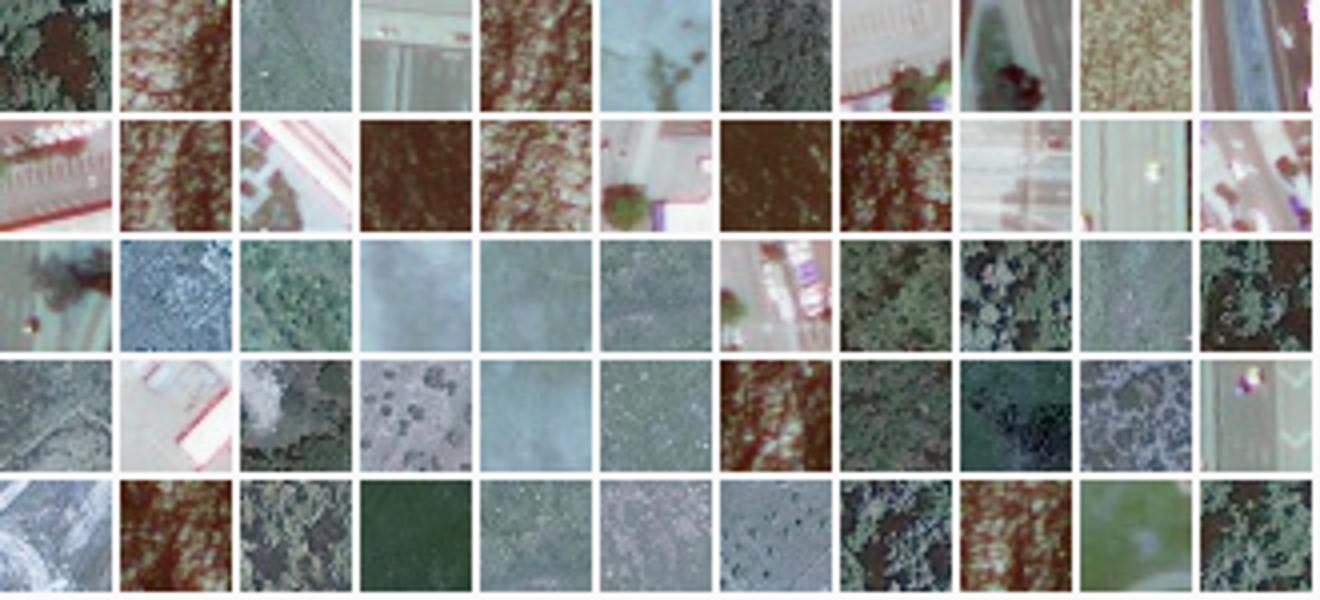

In [54]:
show_collage(examples)

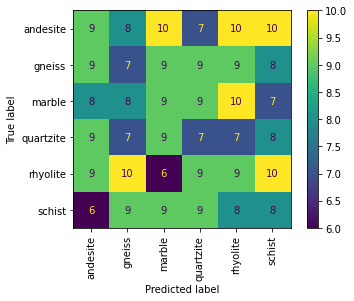

In [14]:
confusion_matrix = np.zeros((num_classes, num_classes))
# For each class.
for class_idx in range(num_classes):
    # Consider 10 examples.
    example_idxs = class_idx_to_test_idxs[class_idx][:10]
    for y_test_idx in example_idxs:
        anchor_near_neighbors = similar_images(near_neighbors_per_example, y_test_idx, test_x)
        for nn_idx in anchor_near_neighbors:
            nn_class_idx = test_labels[nn_idx]
            confusion_matrix[class_idx, nn_class_idx] += 1
labels = [
    "andesite",
    "gneiss",
    "marble",
    "quartzite",
    "rhyolite",
    "schist",
]
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels)
disp.plot(include_values=True, cmap="viridis", ax=None, xticks_rotation="vertical")
plt.show()